In [1]:
import sys

In [2]:
sys.path.append('../../rllab')
import rllab as rl

/home/rex/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
state_dim = 3
num_ctrls = 1

params = rl.ddpg.make_params()
params.max_episodes = 1024
params.actor_hidden_units = [16, 16]
params.critic_hidden_units = [16, 32]
params.eval_interval = 128
params.min_replays = 4096


def transform_obs(obs):
    ret = np.zeros([3])
    ret[0] = (0.3 + obs[0]) / 0.9
    ret[1] = obs[1] / 0.07
    ret[2] = obs[2]
    return ret


def transform_reward(reward):
    return reward / 100.0

ckpt = './nb_mountain_car.ckpt'
gym_env = gym.make('MountainCarContinuous-v0')

print(gym_env.action_space)
print(gym_env.action_space.low)
print(gym_env.action_space.high)

print(gym_env.observation_space)
print(gym_env.observation_space.low)
print(gym_env.observation_space.high)

time_dependent_env = rl.tools.AugmentStateWithTau(gym_env, max_steps=999)

game = rl.tools.GameAdaptor(time_dependent_env,
                            transform_observation_func=transform_obs,
                            transform_reward_func=transform_reward)



WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Box(1,)
[-1.]
[1.]
Box(2,)
[-1.2  -0.07]
[0.6  0.07]


In [5]:
%%time
rl.ddpg.solve(game, state_dim=state_dim, num_controls=num_ctrls,
              params=params, save_path=ckpt, seed=42)

E 128 S 526 TR   0.92 G  -0.01 Reg 0.00000 Loss 0.00011 AvgQ   0.85 MinR  -0.00 MaxR   1.00
******  0.9002004028802417 0.2430886207357169  ******
E 256 S 230 TR   0.96 G   0.08 Reg 0.00000 Loss 0.00006 AvgQ   0.64 MinR  -0.00 MaxR   1.00
******  0.8973507476481429 0.253767470666634  ******
E 384 S 309 TR   0.96 G   0.03 Reg 0.00000 Loss 0.00005 AvgQ   0.59 MinR  -0.00 MaxR   1.00
******  0.9293716889638088 0.29274635788242775  ******
E 512 S 814 TR   0.79 G  -0.03 Reg 0.00000 Loss 0.00008 AvgQ   0.74 MinR  -0.00 MaxR   1.00
******  0.3022264397993836 -0.09928519158128586  ******
E 640 S 215 TR   0.93 G   0.09 Reg 0.00000 Loss 0.00004 AvgQ   0.86 MinR  -0.00 MaxR   1.00
******  0.8823767358092971 0.20826200326324937  ******
E 768 S 144 TR   0.93 G   0.20 Reg 0.00000 Loss 0.00007 AvgQ   0.85 MinR  -0.00 MaxR   1.00
******  0.9046564066017821 0.2488460860552418  ******
E 896 S 126 TR   0.92 G   0.24 Reg 0.00000 Loss 0.00004 AvgQ   0.76 MinR  -0.00 MaxR   1.00
******  0.9024233382074917 0.

INFO:tensorflow:Restoring parameters from ./nb_mountain_car.ckpt


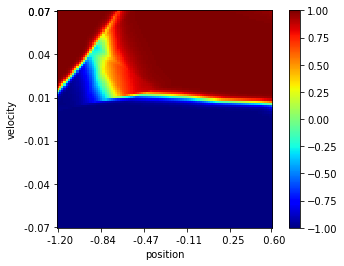

In [6]:
# plot the controls as a function of state at tau = 1.0

control_func = rl.ddpg.Control(state_dim=state_dim, num_controls=num_ctrls, params=params, restore_path=ckpt)

x_axis = np.linspace(-1.2, 0.6, 100)  # position
y_axis = np.linspace(-0.07, 0.07, 101)  # velocity
surface = np.zeros([len(y_axis), len(x_axis)])

for i, y in enumerate(y_axis):
    for j, x in enumerate(x_axis):
        controls = control_func(transform_obs(np.array([x, y, 1.0])))
        surface[i, j] = controls[0]

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(surface, cmap='jet',
               interpolation='nearest',
               origin='lower',
               vmin=-1.0, vmax=1.0,
               #extent=[-1.0, 1.0, -0.07, 0.07]
              )
ax.set_xlabel("position")
ax.set_ylabel("velocity")
fig.colorbar(im)

xticks = np.concatenate([np.arange(0, len(x_axis))[::20], [len(x_axis)-1]])
xticklabels = ["{:6.2f}".format(x_axis[i]) for i in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

yticks = np.concatenate([np.arange(0, len(y_axis))[::20], [len(y_axis)-1]])
yticklabels = ["{:6.2f}".format(y_axis[i]) for i in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

plt.show()


INFO:tensorflow:Restoring parameters from ./nb_mountain_car.ckpt


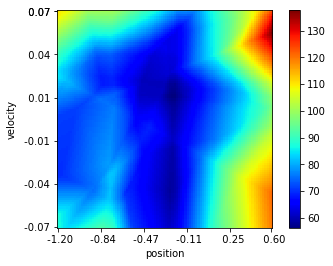

In [7]:
# plot the value as a function of state at tau = 1.0

value_func = rl.ddpg.Value(state_dim=state_dim, num_controls=num_ctrls, params=params, restore_path=ckpt)

x_axis = np.linspace(-1.2, 0.6, 100)  # position
y_axis = np.linspace(-0.07, 0.07, 101)  # velocity
surface = np.zeros([len(y_axis), len(x_axis)])

for i, y in enumerate(y_axis):
    for j, x in enumerate(x_axis):
        surface[i, j] = 100.0 * value_func(transform_obs(np.array([x, y, 1.0])))

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(surface, cmap='jet', interpolation='nearest', origin='lower')
ax.set_xlabel("position")
ax.set_ylabel("velocity")
fig.colorbar(im)

xticks = np.concatenate([np.arange(0, len(x_axis))[::20], [len(x_axis)-1]])
xticklabels = ["{:6.2f}".format(x_axis[i]) for i in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

yticks = np.concatenate([np.arange(0, len(y_axis))[::20], [len(y_axis)-1]])
yticklabels = ["{:6.2f}".format(y_axis[i]) for i in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

plt.show()


In [10]:
anim_path = './MountainCarContinuous-v0.gif'
rl.tools.render(game, control_func=control_func, path=anim_path);

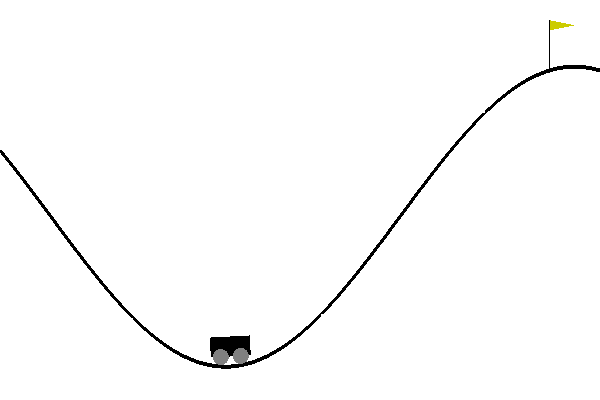

In [20]:
from IPython.display import Image
with open('MountainCarContinuous-v0.gif','rb') as file:
    display(Image(file.read()))